In [1]:
from google.colab import drive
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import IPython.display as ipd
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display
import math
from scipy.io import wavfile
import soundfile as sf
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestCentroid
from sklearn.mixture import GaussianMixture
from sklearn.metrics import pairwise_distances_argmin_min
import csv

In [4]:
datas = pd.read_csv('2D_formants.csv')
data = pd.read_csv('2D_formants.csv',header=None)
data = data.iloc[1:]
data = data.astype(float)

[[-0.66300479 -0.6953903 ]
 [ 0.44265372  0.16479253]
 [-0.91123226  1.99316112]
 [ 1.72628521 -0.09823798]]


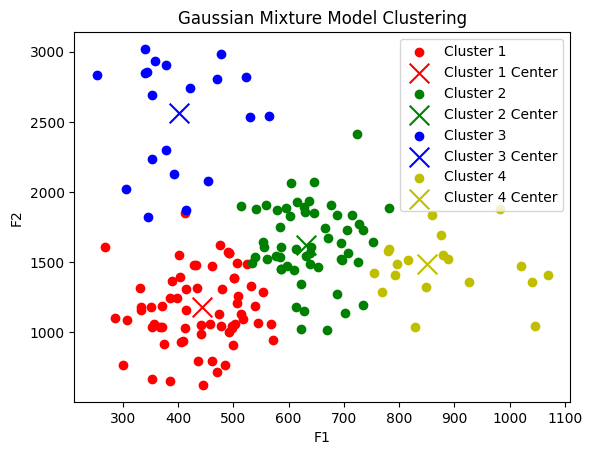

In [5]:
X = datas[['F1', 'F2']]

# Standardize the data (mean=0, std=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit a Gaussian Mixture Model to the data
n_components = 4  # Number of clusters
gmm = GaussianMixture(n_components=n_components, random_state=42)
gmm.fit(X_scaled)

# Predict the cluster assignments for each data point
labels = gmm.predict(X_scaled)

# Get the means and covariances of the Gaussian components
means = scaler.inverse_transform(gmm.means_)
covariances = gmm.covariances_
print(gmm.means_)
# Plot the data points and cluster centers
colors = ['r', 'g', 'b','y']
for i in range(n_components):
    plt.scatter(X['F1'][labels == i], X['F2'][labels == i], c=colors[i], label=f'Cluster {i + 1}')
    plt.scatter(means[i, 0], means[i, 1], c=colors[i], marker='x', s=200, label=f'Cluster {i + 1} Center')

plt.xlabel('F1')
plt.ylabel('F2')
plt.title('Gaussian Mixture Model Clustering')
plt.legend()
plt.show()

In [6]:
from sklearn.cluster import KMeans
K = 4

# Initialize and fit the K-Means model
kmeans = KMeans(n_clusters=K, random_state=0)
cluster_labels = kmeans.fit_predict(X_scaled)

# Get cluster centers (means)
cluster_centers = kmeans.cluster_centers_

# Calculate cluster weights (proportions)
cluster_weights = []
for k in range(K):
    weight = np.mean(cluster_labels == k)
    cluster_weights.append(weight)

# Calculate covariance matrices for each cluster
covariance_matrices = []
for k in range(K):
    cluster_data = X_scaled[cluster_labels == k]
    covariance_matrix = np.cov(cluster_data, rowvar=False)
    covariance_matrices.append(covariance_matrix)

# Now, cluster_centers, cluster_weights, and covariance_matrices contain the required information.

print("Cluster Centers (Means):")
print(cluster_centers.shape)

print("Cluster Weights (Proportions):")
print(len(cluster_weights))

print("Covariance Matrices:")
for k in range(K):
    print(f"Cluster {k} Covariance Matrix:")
    print(covariance_matrices[k])
cluster_centers = cluster_centers.T

Cluster Centers (Means):
(4, 2)
Cluster Weights (Proportions):
4
Covariance Matrices:
Cluster 0 Covariance Matrix:
[[ 0.38467369 -0.03253443]
 [-0.03253443  0.20235696]]
Cluster 1 Covariance Matrix:
[[ 2.01758885e-01 -4.46634708e-05]
 [-4.46634708e-05  2.37219636e-01]]
Cluster 2 Covariance Matrix:
[[ 0.24539316 -0.0031274 ]
 [-0.0031274   0.41549021]]
Cluster 3 Covariance Matrix:
[[ 0.20703219 -0.02402922]
 [-0.02402922  0.22348395]]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [7]:
def initialization(data,K):

  # write your code here
  d=data.shape[1] # dimension of data



  means=cluster_centers


# covariance matrix initialization
  Covariance=np.zeros((d,d,K))
  for i in range(K):
    Covariance[:,:,i]=covariance_matrices[k]

#mixing coefficients
  proportions=cluster_weights

  theta=[means,Covariance,proportions]

  Cents=means.T

  return theta

In [8]:
# E-Step GMM
from scipy.stats import multivariate_normal

def E_Step_GMM(data,K,theta):

    # write your code here
    means=theta[0]
    Covariance=theta[1]
    proportions=theta[2]
    #Computing responsibility coefficients of each point for each cluster.
    responsibility=np.zeros((len(data),K))
    for i in range(K):
        itr=0   # increase w.r.t datapoint
        for x in data:
            normalising=0
# Compute probability of xj for cluster i
            N_xn=multivariate_normal.pdf(x,mean=means[:,i], cov=Covariance[:,:,i])

            # # only to avoid
            #if N_xn<10**(-20):
              #N_xn=10**(-20)



            responsibility[itr][i]=proportions[i]*N_xn

            for j in range(K):
                normalising+=proportions[j]*(multivariate_normal.pdf(x,mean=means[:,j], cov=Covariance[:,:,j])+10**(-20))
            responsibility[itr][i]=responsibility[itr][i]/normalising
            itr+=1

    return responsibility

In [9]:
# M-STEP GMM

def M_Step_GMM(data,responsibility):

    # write your code here
    [N,K]=np.shape(responsibility) #N is number of data points
    d=data.shape[1]

    #Compute Proportions
    Nk=np.sum(responsibility,axis=0)
    proportions=Nk/N

    #Compute Means
    means=np.zeros((K,d))
    for k in range(K):
        temp1=data
        temp2=responsibility[:,k]
        temp2 = temp2.reshape(-1, 1)
        temp = temp2 * temp1
        #multiplying a vector with multiple columns
        means[k]=(1/Nk[k])*np.sum(temp,axis=0)
    means=np.transpose(means)

    #Compute Covariance
    Covariance=np.zeros((d,d,K))
    for k in range(K):
        for n in range(N):
            temp1=data[n,:]-means[:,k]

            temp2=np.outer(temp1,np.transpose(temp1)) # vector outer product
            temp=responsibility[n,k]*temp2
            Covariance[:,:,k]+=temp
        Covariance[:,:,k]=(1/Nk[k])*Covariance[:,:,k]

    theta=[means,Covariance,proportions]
    Likelihood=0
    log_likelihood=0
    for n in range(N):
        for k in range(K):

          epsilon = 1e-6
          Covariance[:,:,k] += epsilon * np.eye(Covariance.shape[0])

          Likelihood+=proportions[k]*(multivariate_normal.pdf(data[n,:],mean=means[:,k], cov=Covariance[:,:,k],allow_singular=True))
        log_likelihood+=np.log(Likelihood)

    return theta, log_likelihood

<ipython-input-10-ae4c9d417ce1>:25: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(X_scaled[id,0],X_scaled[id,1],'.',color=clr[l],marker=mrk[l])
<ipython-input-10-ae4c9d417ce1>:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


[[ 1.50431676 -0.05402343]
 [ 0.29967422  0.08233977]
 [-0.9262531   1.85035715]
 [-0.74341132 -0.82706519]]


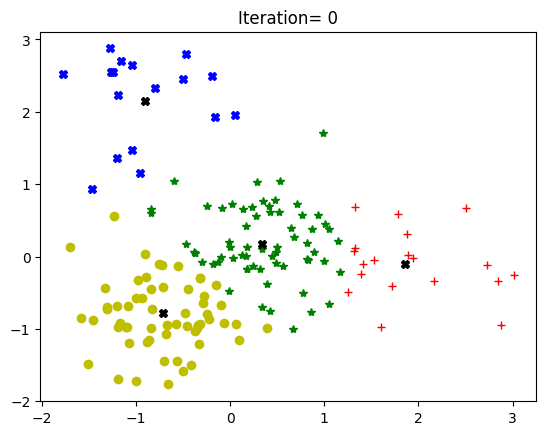

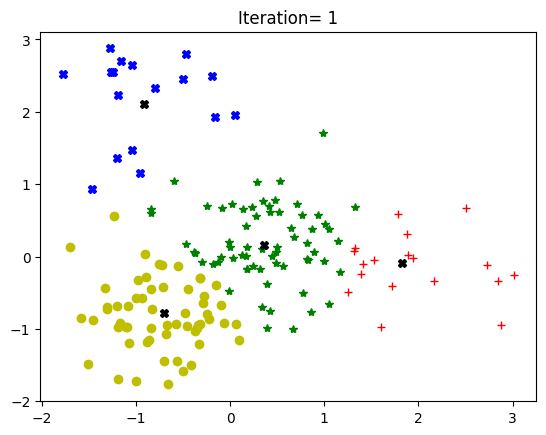

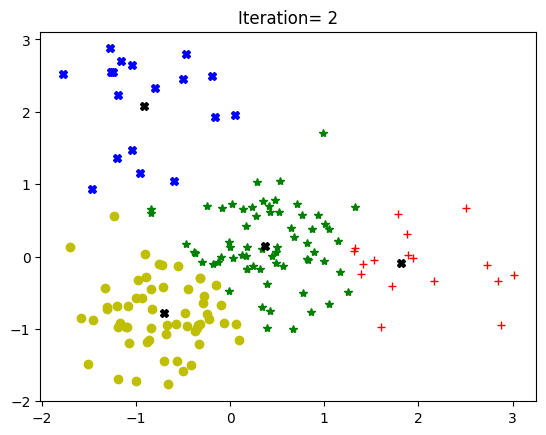

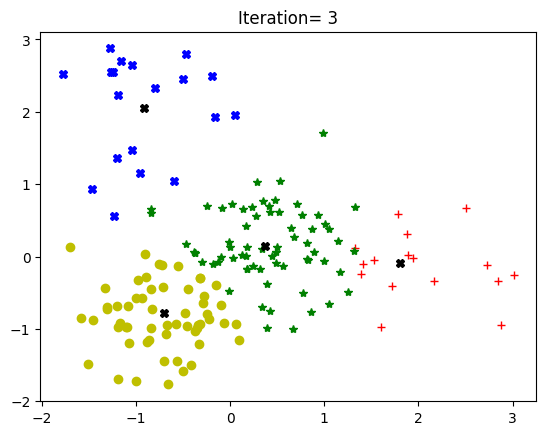

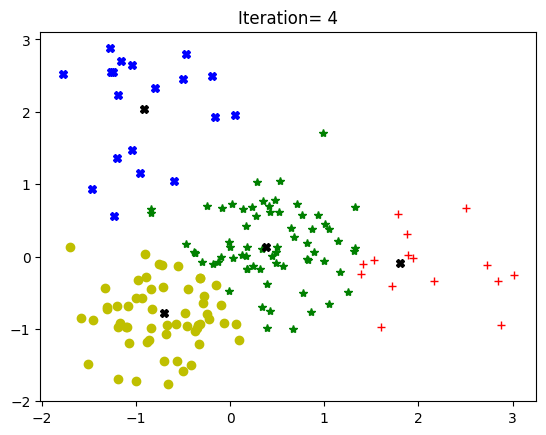

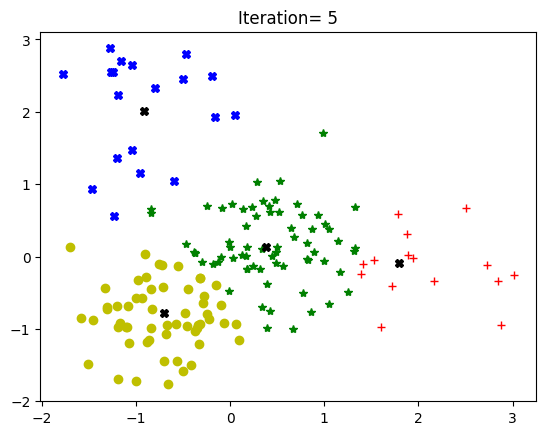

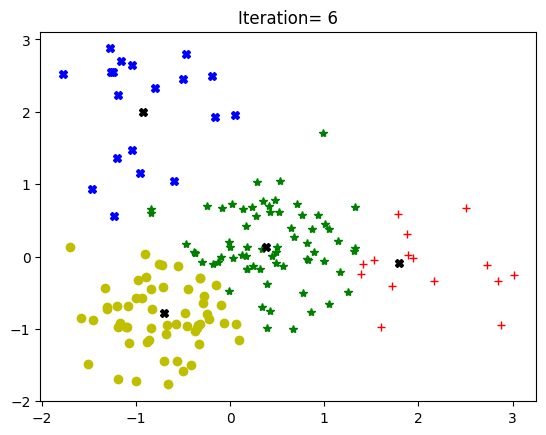

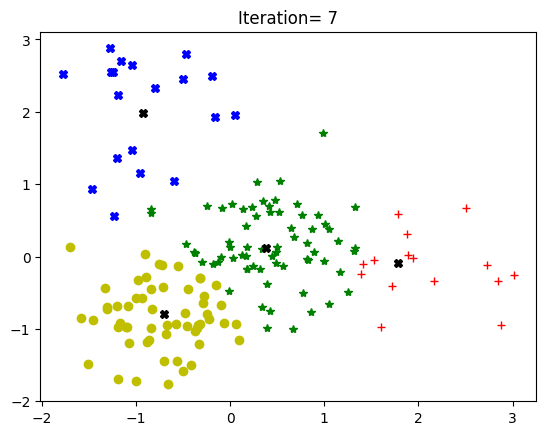

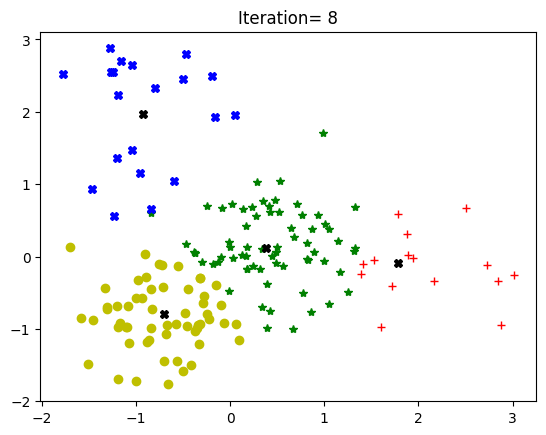

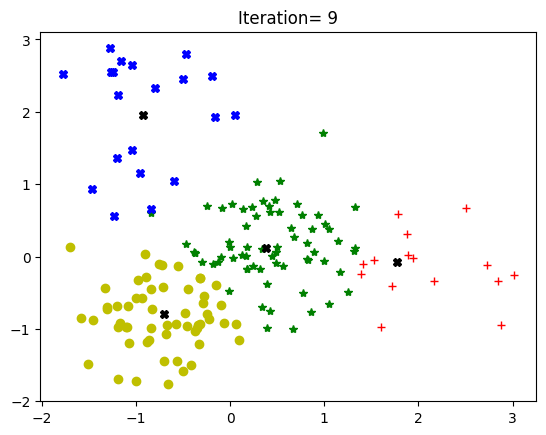

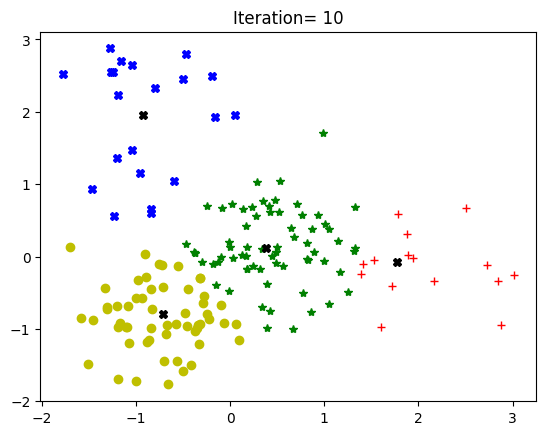

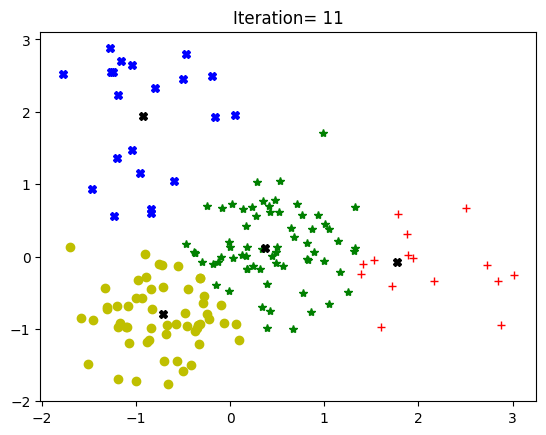

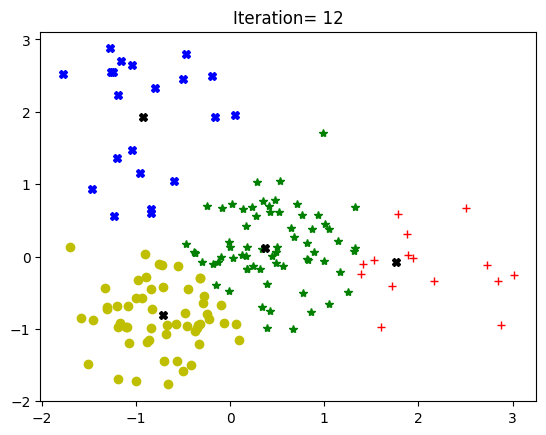

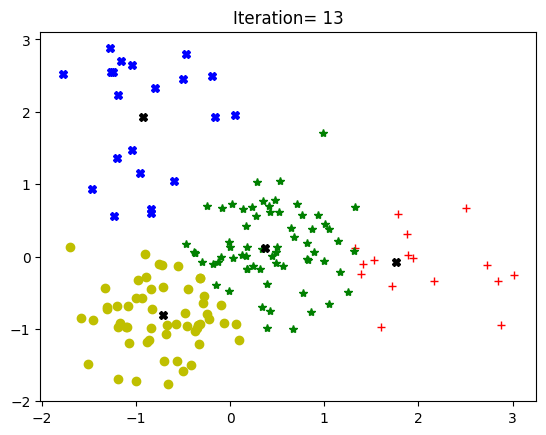

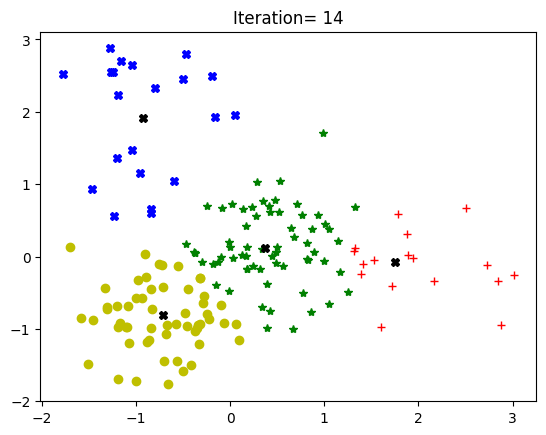

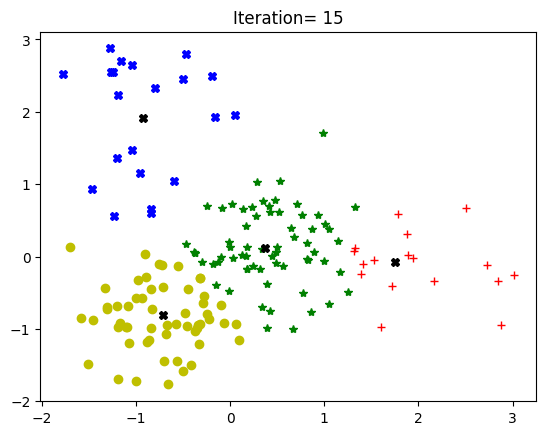

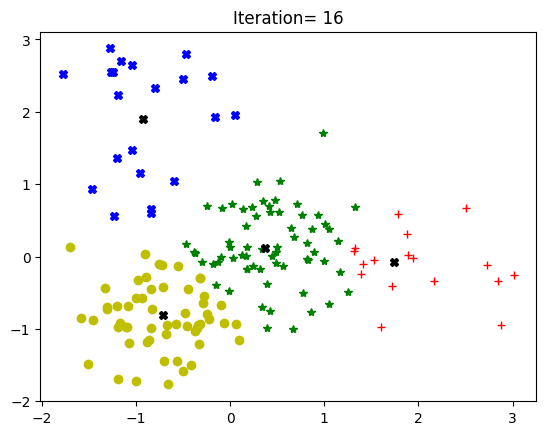

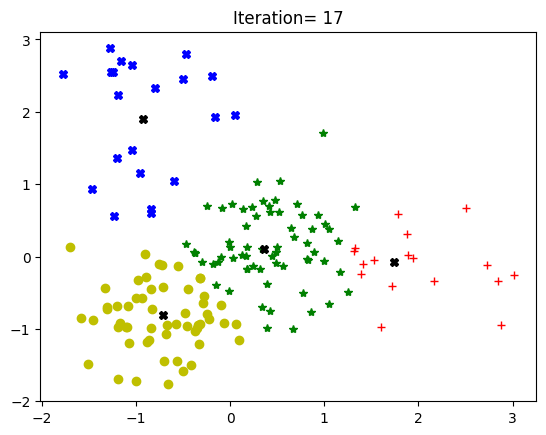

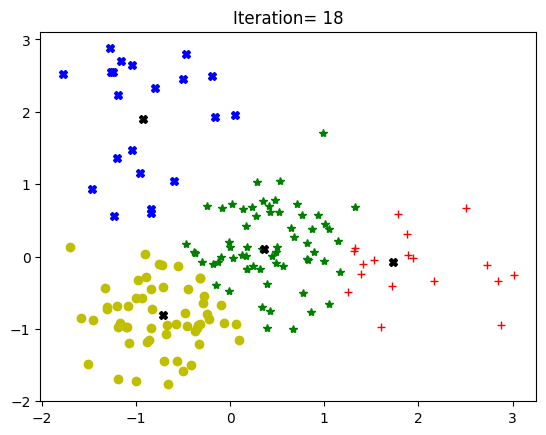

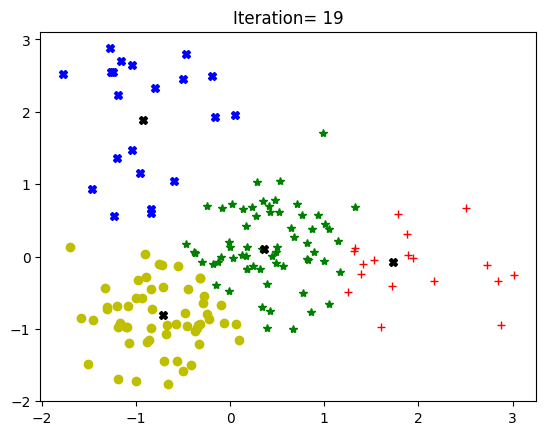

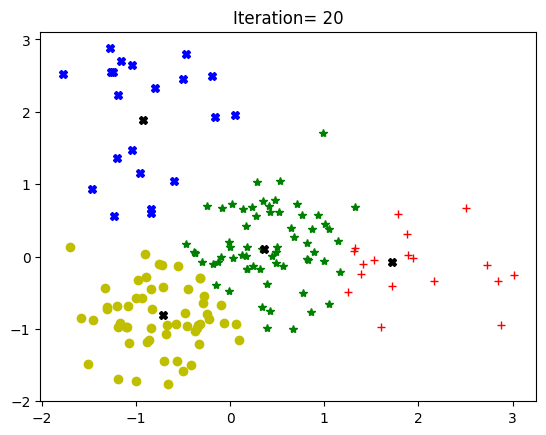

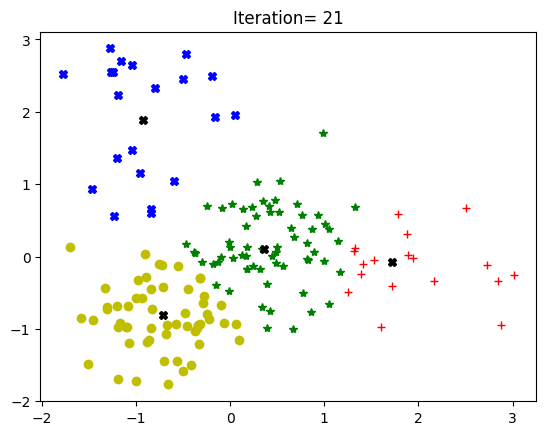

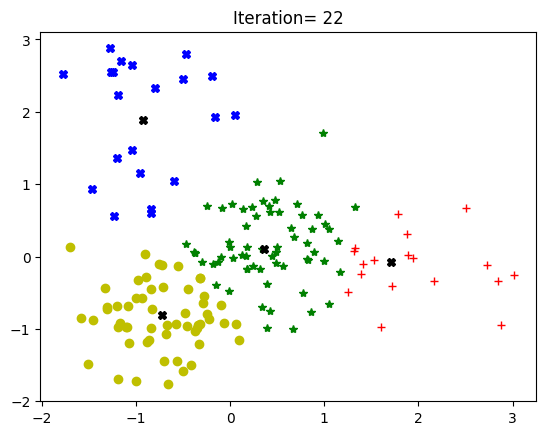

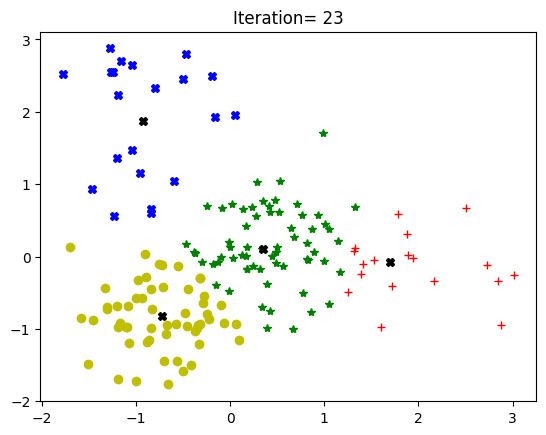

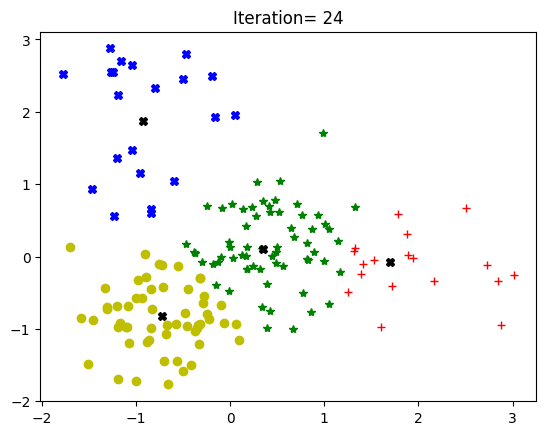

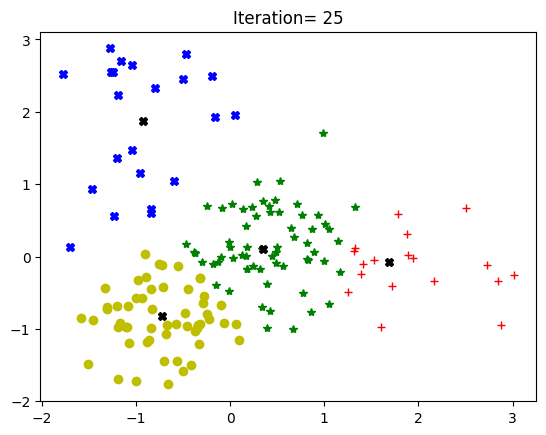

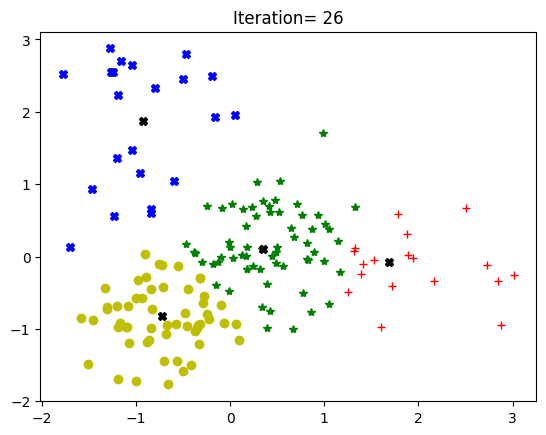

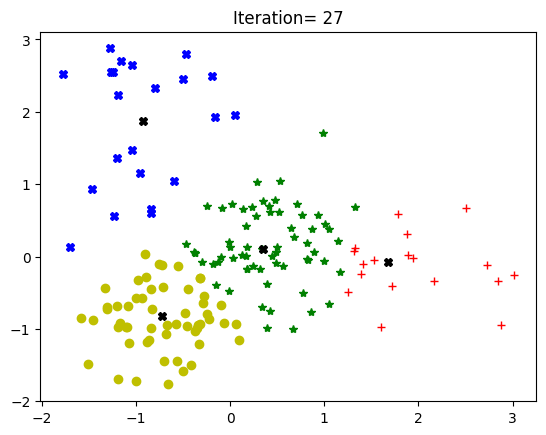

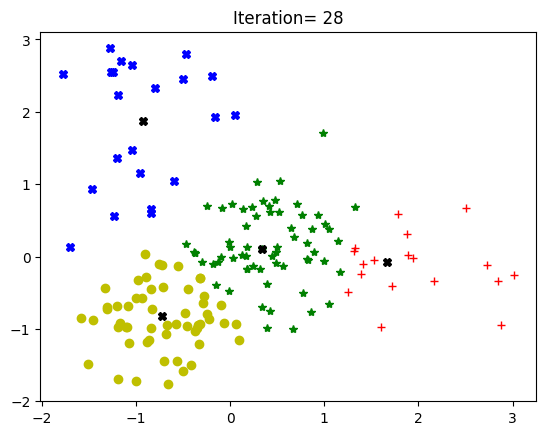

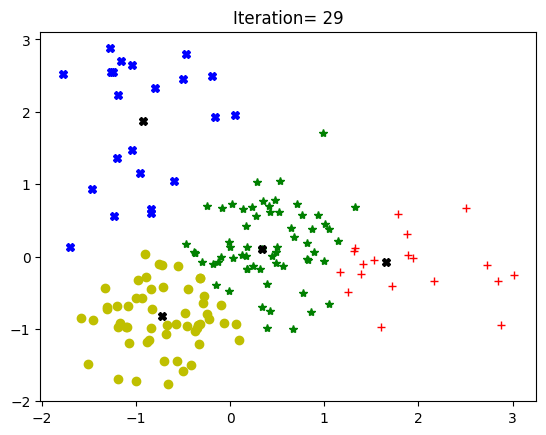

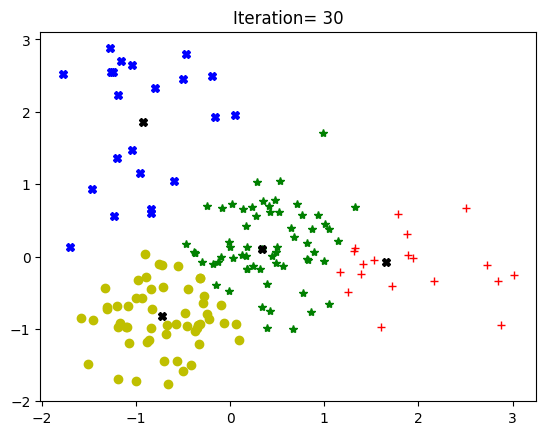

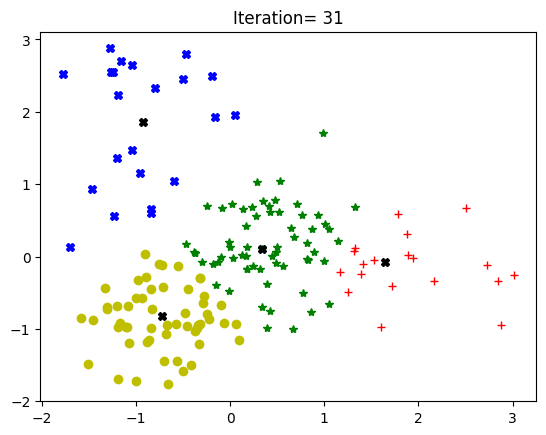

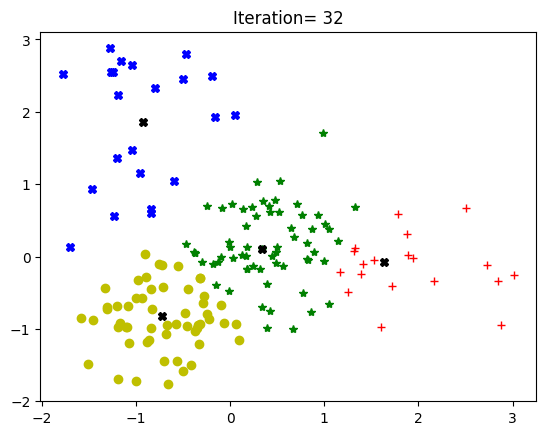

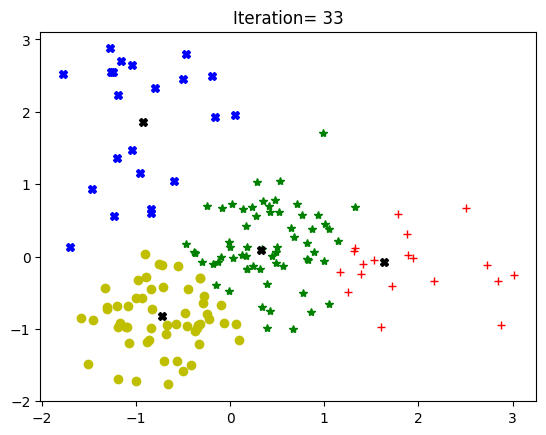

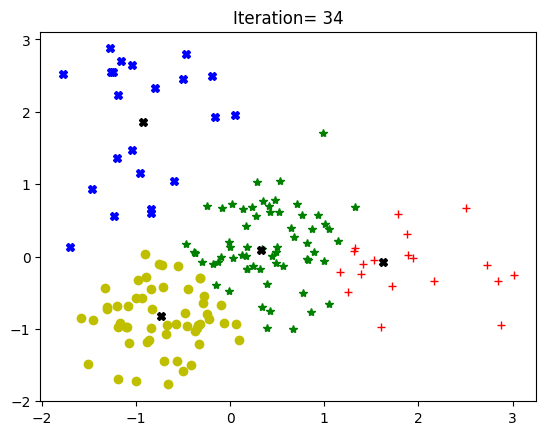

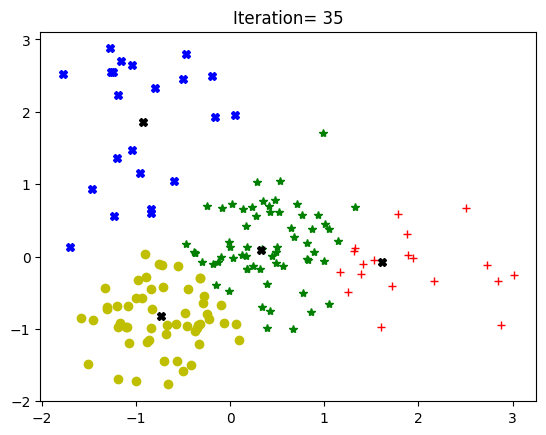

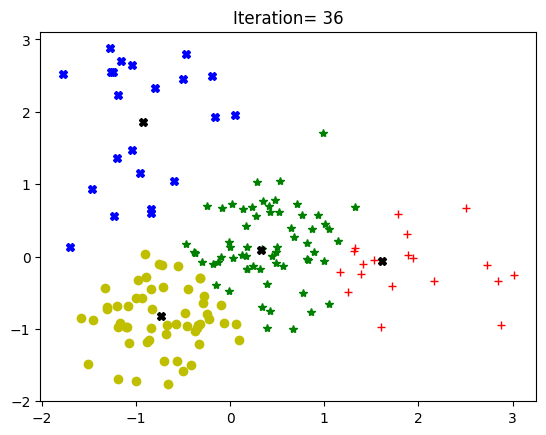

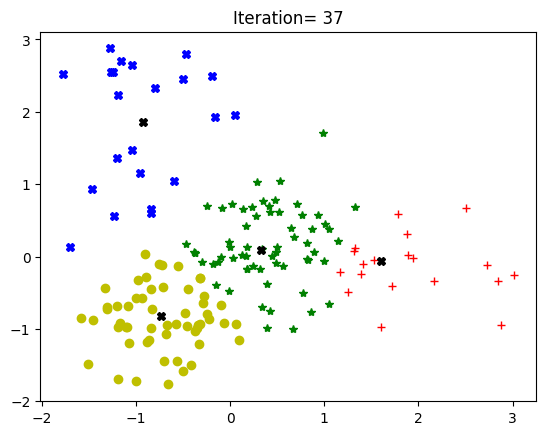

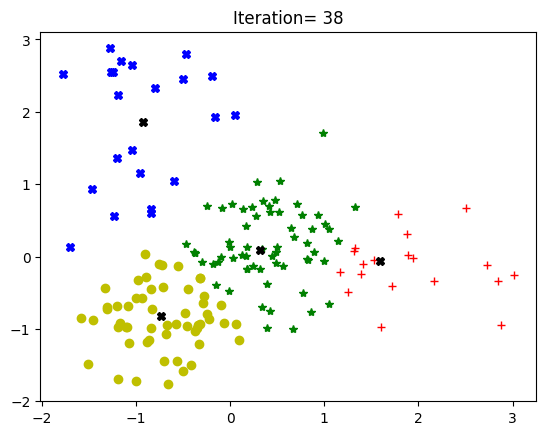

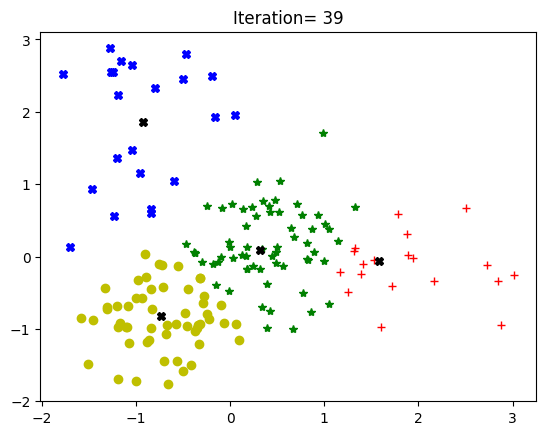

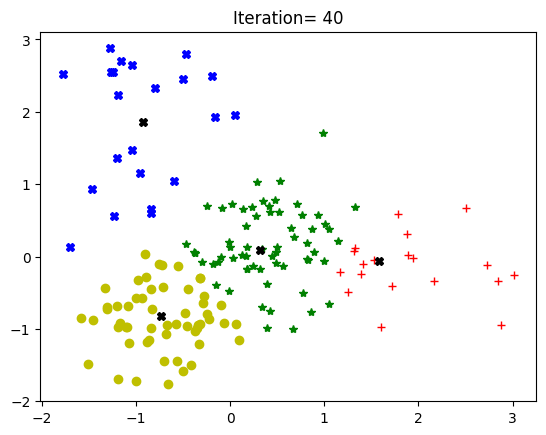

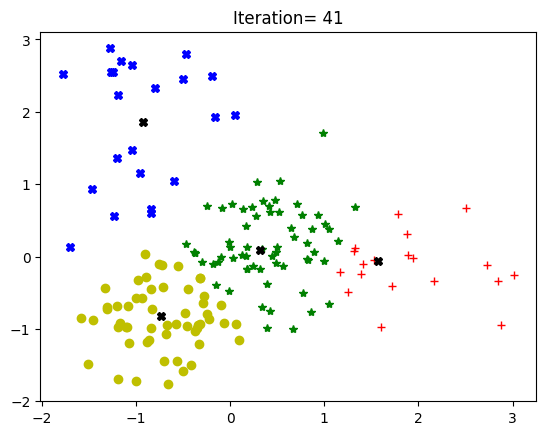

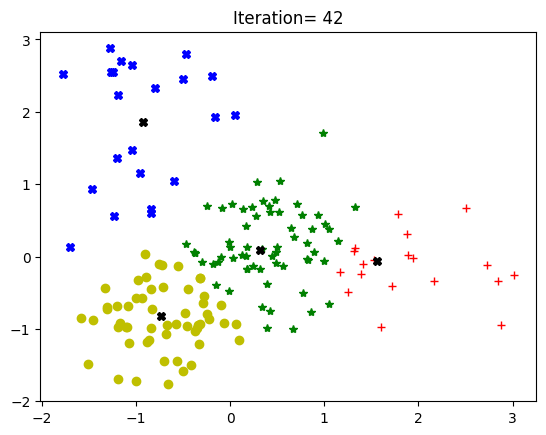

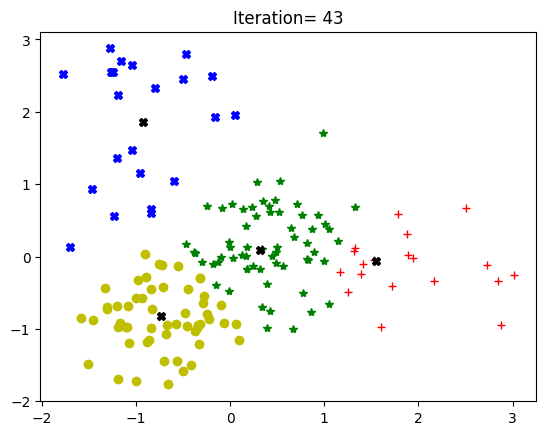

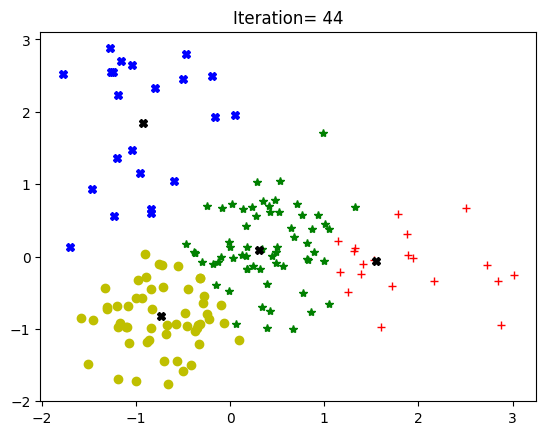

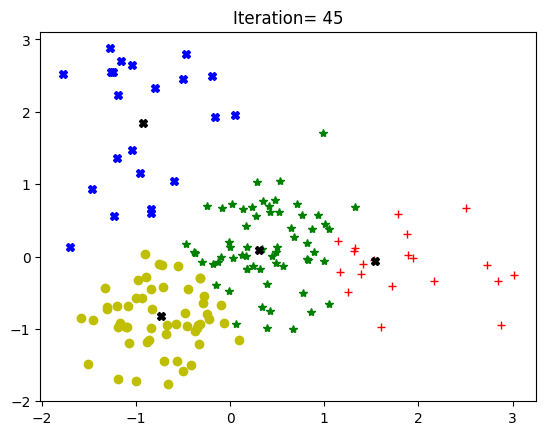

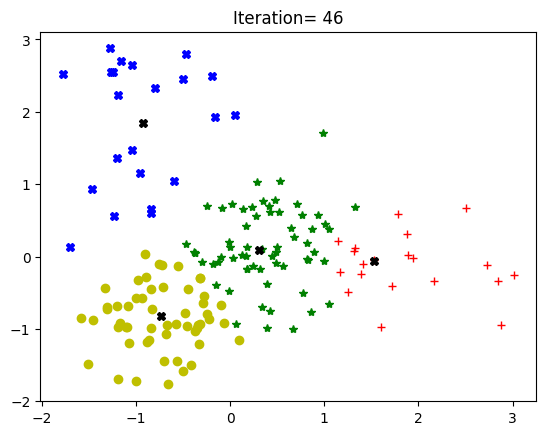

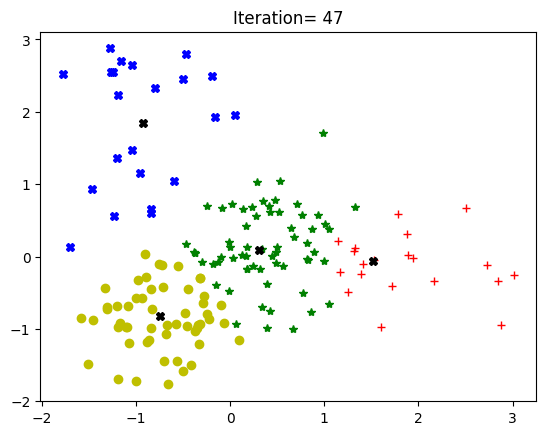

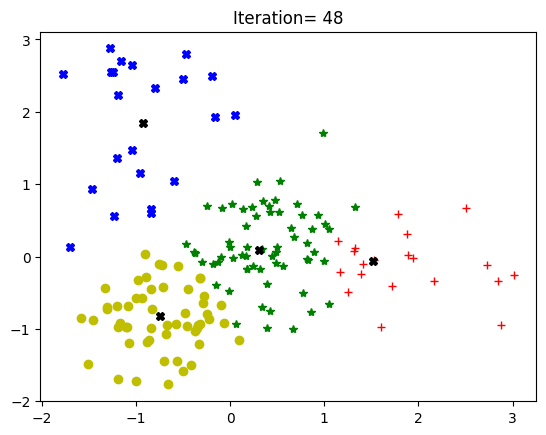

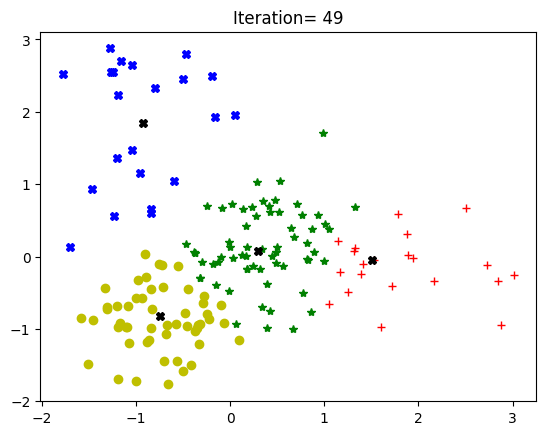

<Figure size 640x480 with 0 Axes>

In [10]:
log_l=[]
Itr=50
eps=10**(-14)  # for threshold
clr=['r','g','b','y','k','m','c']
mrk=['+','*','X','o','.','<','p']


K = 4   # no. of clusters

theta=initialization(X_scaled,K)
for n in range(Itr):

  responsibility=E_Step_GMM(X_scaled,K,theta)

  cluster_label=np.argmax(responsibility,axis=1) #Label Points

  theta,log_likhd=M_Step_GMM(X_scaled,responsibility)

  log_l.append(log_likhd)

  plt.figure()
  for l in range(K):
    id=np.where(cluster_label==l)

    plt.plot(X_scaled[id,0],X_scaled[id,1],'.',color=clr[l],marker=mrk[l])
  Cents=theta[0].T

  plt.plot(Cents[:,0],Cents[:,1],'X',color='k')
  plt.title('Iteration= %d' % (n))

  if n>2:
    if abs(log_l[n]-log_l[n-1])<eps:
      break


plt.figure()
print(Cents)

In [12]:
data = pd.read_csv('train_data.csv')

# Specify which columns to use as features (X)
feature_columns = ['F1', 'F2', 'F3','F4', 'F5', 'F6','F7', 'F8', 'F9','F10', 'F11', 'F12', 'F13']  # Replace with the actual column names you want as features

# Create your feature data (X)
X = data[feature_columns]

# If you want to select all columns except the label column (y), you can do:
# X = data.drop('label_column_name', axis=1)

# Separate the labels (y) into another variable
y = data['Label']

X_train, X_testi, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_testi)
with open('/content/drive/MyDrive/test.csv', 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    for testi in X_test:
        csv_writer.writerow(testi)

with open('/content/drive/MyDrive/train.csv', 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    for traini in X_train:
        csv_writer.writerow(traini)

with open('/content/drive/MyDrive/labels.csv', 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(y_train)

In [13]:
n_components = 1

# Store cluster centers for each class
cluster_centers = []

for i in range(1, 7):
    data = pd.read_csv(f'{i}_train.csv')
      # Number of clusters
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(data)
    cluster_centers.append(gmm.means_)
cluster_centers = np.array(cluster_centers)

In [14]:
print(cluster_centers)

[[[ 0.32747427  0.72524002 -0.29016403 -0.92071254 -1.17586996
   -0.56066978 -0.17199109  0.44585659  0.88340467  0.08699825
    0.37884032  0.9950902   1.05983179]]

 [[ 0.59632203  0.14393709 -1.34229354 -1.17897428 -0.6559244
    0.98806439  0.55671373  0.77662749  0.36591326  1.29881402
    0.88221805 -0.79281101 -0.72633715]]

 [[-0.55059028 -0.6124854   0.8104262   0.82136322  0.37626997
    0.73750637  0.66633281 -0.45495892 -0.14651077 -0.18838519
   -0.48135917 -0.08080915 -0.49454576]]

 [[-0.45506008  1.01713319  1.12303689 -0.34632561  0.53327777
   -0.01555271 -0.65578166 -0.40196828  0.18005065 -0.15539482
   -0.57981476 -0.52650682  0.18616568]]

 [[-0.27332339 -0.52196291  0.18315734  0.9321384   0.94632847
   -0.31330865 -0.01161077  0.09557309 -0.4360509  -0.8833951
   -0.37538285  0.25264097 -0.19391508]]

 [[ 0.20754266 -0.75837631 -0.22183016  0.91692455  0.1403058
   -0.99936053 -0.39603406 -0.54820068 -0.91788449 -0.44896434
    0.07892444  0.29021112  0.2967403

In [15]:
class_predictions = []
X_testii = pd.read_csv('test.csv')
# Calculate distances to each class's cluster centers and find the nearest
for data_point in X_testii.values:
    distances = [pairwise_distances_argmin_min([data_point], centers)[1][0] for centers in cluster_centers]
    predicted_class = np.argmin(distances) + 1  # Add 1 to get the class label
    class_predictions.append(predicted_class)

# 'class_predictions' now contains the predicted class labels for each data point in X_train
print("Class Predictions:", class_predictions)

Class Predictions: [2, 5, 3, 5, 4, 6, 1, 1, 1, 4, 3, 4, 3, 3, 5, 1, 5, 3, 4, 3, 6, 5, 4, 4, 3, 4, 1, 6, 1, 5, 4, 4, 1, 3, 6, 1, 3, 5, 6]


**Speaker recognition:**

In [206]:
data_speak = pd.read_csv('total_speakers_data.csv')

# Specify which columns to use as features (X)
feature_columns = ['0','1', '2', '3','4', '5', '6','7', '8', '9','10', '11', '12']  # Replace with the actual column names you want as features

# Create your feature data (X)
X_speak = data_speak[feature_columns]

# If you want to select all columns except the label column (y), you can do:
# X = data.drop('label_column_name', axis=1)

# Separate the labels (y) into another variable
y_speak = data_speak['Label']

X_train_speak, X_testi_speak, y_train_speak, y_test_speak = train_test_split(X_speak, y_speak, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_speak = scaler.fit_transform(X_train_speak)
X_test_speak = scaler.transform(X_testi_speak)
print(X_testi_speak)
print(y_test_speak)
with open('sp_test.csv', 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    for testi in X_test_speak:
        csv_writer.writerow(testi)

with open('sp_train.csv', 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    for traini in X_train_speak:
        csv_writer.writerow(traini)

with open('sp_labels_train.csv', 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(y_train_speak)

input_csv_file = 'sp_labels_train.csv'
data = pd.read_csv(input_csv_file)

# Transpose the data
transposed_data = data_speak.T
y_train_speak = y_train_speak.to_numpy()
y_train_speak = y_train_speak.reshape(-1, 1)
# Specify the path for the output transposed CSV file
output_csv_file = 'transposed_sp_labels_train.csv'
resulting_array = np.zeros((y_train_speak.shape[0], y_train_speak.shape[1]+X_train_speak.shape[1]))
resulting_array[:, :X_train_speak.shape[1]] = X_train_speak

# Copy the data from the second array into the new array
y_test_speak = y_test_speak.to_numpy()
y_test_speak = y_test_speak.reshape(-1, 1)
resulting_array[:, X_train_speak.shape[1]:] = y_train_speak
resulting_array_test = np.zeros((y_test_speak.shape[0], y_test_speak.shape[1]+X_test_speak.shape[1]))
resulting_array_test[:, :X_test_speak.shape[1]] = X_test_speak
resulting_array_test[:, X_test_speak.shape[1]:] = y_test_speak
output_csv_file_test = 'transposed_sp_labels_test.csv'
np.savetxt(output_csv_file_test, resulting_array_test, delimiter=',', fmt='%f')
# Save the transposed data to a new CSV file
print(y_train_speak.shape)
np.savetxt(output_csv_file, resulting_array, delimiter=',', fmt='%f')

               0           1           2          3          4          5  \
23314 -402.09335   61.521120  -54.017563  56.598854 -19.403076 -26.963170   
22426 -149.54535  180.279940 -135.324950 -19.793167 -60.723698 -49.786224   
12277 -231.06613  168.708620  -90.805176  46.892204 -10.833060 -32.086670   
24965 -233.08076  179.209460 -101.367660  15.846088  23.874023 -19.836489   
27191 -144.09564  204.748200 -103.711040  38.654230   0.602886 -44.574207   
...          ...         ...         ...        ...        ...        ...   
16423 -141.22458  192.081710 -100.339660   7.531484 -51.473557 -48.223804   
3274  -225.99718  103.742325 -103.744510  61.169327 -72.014680 -67.240610   
13049 -457.59677   19.438602  -40.936790  31.409012 -14.861052  -0.896508   
2425  -307.86743  108.683240  -42.443913   6.485458  -8.040903 -28.650250   
18857 -262.41162  171.664520  -44.775597  -4.337765 -77.571580 -62.144375   

               6          7          8          9         10         11  \


In [207]:
df = pd.read_csv('transposed_sp_labels_train.csv', header=None)  # Adjust the file name
print(df.shape)
for value in range(1, 31):

  # Filter rows with the current last column value
  df_filtered = df[df.iloc[:, -1] == value]
  print(df_filtered)
  # Save the filtered DataFrame to a CSV file
  filename = f'{value}.csv'  # File name based on the last column value
  df_filtered.to_csv(filename, sep='\t', header=False, index=False)


(23008, 14)
             0         1         2         3         4         5         6   \
19     0.260747  0.126717 -0.024801 -0.663869  0.421700 -0.023704 -1.364017   
25     1.080190  0.053357 -2.220318 -1.606691 -2.449666 -0.005193  1.680215   
36     0.171848 -0.391270  0.192626  1.875500 -0.564947 -0.939901  1.107496   
49    -2.044774 -1.596951  1.514551 -1.075823  0.373394  1.344735  0.503319   
56     1.130170  0.155493 -1.972841 -1.671466 -0.661643  0.676761  1.197032   
...         ...       ...       ...       ...       ...       ...       ...   
22915  1.339513  0.665033 -1.940954 -1.772165 -0.091851 -0.780828 -2.605153   
22925  0.477200  0.410306 -0.916124 -2.423748 -0.190989  0.348219 -2.147123   
22967  0.031180 -1.021405 -0.090984  0.575626 -0.166644  0.347479  0.819492   
22988 -0.437872 -0.362218  0.389762 -1.441222 -0.747965  1.319051 -0.586955   
23005 -0.288637 -0.450004 -0.015550 -0.296592  0.310142 -0.494634 -1.180486   

             7         8         9     

In [208]:
P = 1

# Store cluster centers for each class
cluster_center = []

for i in range(1, 31):
  print(i)
  data = pd.read_csv(f'{i}.csv',sep='\t')
  data = data.iloc[:, :-1]
  gmm = GaussianMixture(n_components=n_components, random_state=42)
  gmm.fit(data)
  cluster_center.append(gmm.means_)
cluster_center = np.array(cluster_center)

print(cluster_center)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
[[[-1.57843589e-01 -5.59383675e-01 -4.81774002e-02 -3.10544761e-01
   -2.94783405e-01  1.04775219e-03 -2.11321162e-01 -5.87095154e-02
    7.83730592e-03 -1.70992118e-01 -6.40618936e-02  2.38874634e-01
    3.74310019e-01]]

 [[ 2.48357372e-01 -4.02764648e-02 -2.16565728e-02  5.31583142e-03
   -9.63083355e-02 -1.50423591e-01  1.01428219e-01 -3.09913028e-02
   -4.27174124e-01 -2.96902450e-01 -2.00305802e-01 -9.24144926e-02
    9.88495205e-02]]

 [[ 3.55450389e-02 -1.86054955e-01 -1.04198248e-01 -1.55904731e-01
    2.26611213e-01 -1.85027263e-01 -4.04306588e-01  2.17280880e-01
   -9.34813789e-02 -2.87268055e-02 -5.19080113e-02 -4.62801625e-01
    4.29622572e-01]]

 [[ 9.62105789e-02  1.56226466e-03  1.52587677e-01 -2.00058570e-01
    5.26637654e-02 -2.69073722e-01 -3.14747720e-01  3.48673653e-01
   -1.86737932e-01  1.61997459e-02  1.87543985e-02 -6.77556836e-01
    1.77590435e-01]]

 [[ 3.80680459e-03 -1.35757

In [209]:
class_prediction = []
X_testii = pd.read_csv('sp_test.csv')
# Calculate distances to each class's cluster centers and find the nearest
for data_point in X_testii.values:
  print(X_testii.values[0])
  distances = [pairwise_distances_argmin_min([data_point], centers)[1][0] for centers in cluster_center]
  predicted_class = np.argmin(distances) + 1  # Add 1 to get the class label
  class_prediction.append(predicted_class)

# 'class_predictions' now contains the predicted class labels for each data point in X_train
print("Class Predictions:", class_prediction)

Streaming output truncated to the last 5000 lines.
 -1.2841317 ]
[ 1.28541803  0.96060161 -1.50879548 -1.30329412 -1.67762909 -0.82809025
  1.01114362 -0.67617487 -1.23857098  0.64786639  1.18837894  1.79511159
 -1.2841317 ]
[ 1.28541803  0.96060161 -1.50879548 -1.30329412 -1.67762909 -0.82809025
  1.01114362 -0.67617487 -1.23857098  0.64786639  1.18837894  1.79511159
 -1.2841317 ]
[ 1.28541803  0.96060161 -1.50879548 -1.30329412 -1.67762909 -0.82809025
  1.01114362 -0.67617487 -1.23857098  0.64786639  1.18837894  1.79511159
 -1.2841317 ]
[ 1.28541803  0.96060161 -1.50879548 -1.30329412 -1.67762909 -0.82809025
  1.01114362 -0.67617487 -1.23857098  0.64786639  1.18837894  1.79511159
 -1.2841317 ]
[ 1.28541803  0.96060161 -1.50879548 -1.30329412 -1.67762909 -0.82809025
  1.01114362 -0.67617487 -1.23857098  0.64786639  1.18837894  1.79511159
 -1.2841317 ]
[ 1.28541803  0.96060161 -1.50879548 -1.30329412 -1.67762909 -0.82809025
  1.01114362 -0.67617487 -1.23857098  0.64786639  1.18837894  

In [210]:
y_test = y_test[1:]
print(y_test)

[[20]
 [27]
 [23]
 ...
 [10]
 [ 3]
 [16]]


In [211]:
correct_pred = sum(1 for predicted, actual in zip(class_prediction, y_test) if predicted == actual)

# Calculate the accuracy
accuracy = correct_pred / len(y_test) * 100  # Convert to percentage

print(f"Accuracy: {accuracy:.2f}%")



Accuracy: 12.34%
